In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = 'True',
    transform = ToTensor(),
    download = 'True'
)
test_data = datasets.MNIST(
    root = 'data',
    train = 'False',
    transform = ToTensor(),
    download = 'True'
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
test_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_data.targets.size()

torch.Size([60000])

In [8]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data,
                         batch_size = 100,
                         shuffle = True,
                         num_workers = 1),
    'test' : DataLoader(test_data,
                        batch_size = 100,
                        shuffle = True,
                        num_workers = 1),
}

In [10]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1c1d9a90ce0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1c1d9a53c80>}

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super (CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to (device)
optimizer = optim.Adam(model.parameters(),lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
def train(epoch):
    model.train()
    for batch_idx,(data,target) in enumerate (loaders['train']):
        data,target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} 'f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data,target = data.to(device),target.to(device)
            output = model(data)
            test_loss += loss_fn(output,target).item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss / len(loaders['test'].dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} 'f'({100. * correct / len(loaders["test"].dataset):.0f}%)\n')


In [13]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	2.305080
Train Epoch: 1 [2000/60000 (3%)]	2.214529
Train Epoch: 1 [4000/60000 (7%)]	1.807239
Train Epoch: 1 [6000/60000 (10%)]	1.351202
Train Epoch: 1 [8000/60000 (13%)]	0.954161
Train Epoch: 1 [10000/60000 (17%)]	0.887260
Train Epoch: 1 [12000/60000 (20%)]	0.700075
Train Epoch: 1 [14000/60000 (23%)]	0.645096
Train Epoch: 1 [16000/60000 (27%)]	0.618720
Train Epoch: 1 [18000/60000 (30%)]	0.492704
Train Epoch: 1 [20000/60000 (33%)]	0.677860
Train Epoch: 1 [22000/60000 (37%)]	0.639738
Train Epoch: 1 [24000/60000 (40%)]	0.517171
Train Epoch: 1 [26000/60000 (43%)]	0.435164
Train Epoch: 1 [28000/60000 (47%)]	0.587944
Train Epoch: 1 [30000/60000 (50%)]	0.610871
Train Epoch: 1 [32000/60000 (53%)]	0.721187
Train Epoch: 1 [34000/60000 (57%)]	0.629376
Train Epoch: 1 [36000/60000 (60%)]	0.505607
Train Epoch: 1 [38000/60000 (63%)]	0.477417
Train Epoch: 1 [40000/60000 (67%)]	0.620824
Train Epoch: 1 [42000/60000 (70%)]	0.511561
Train Epoch: 1 [44000/60000 (73%)]	0.571603

In [14]:
device

device(type='cpu')

Prediction: 0


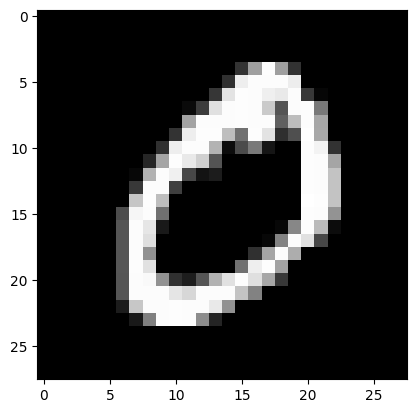

In [15]:
import matplotlib.pyplot as plt
model.eval()
data, target = test_data[1]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim = 1, keepdim = True).item()
print(f'Prediction: {prediction}')
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap = 'gray')
plt.show()